In [1]:
#libraries
import numpy as np 
import pandas as pd 
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools

In [2]:
# Quadratic Kappa function
def quadratic_kappa(actuals, preds, N=5):
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values 
    of adoption rating."""
    w = np.zeros((N,N))
    O = confusion_matrix(actuals, preds)
    for i in range(len(w)): 
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(N-1)**2)
    
    act_hist=np.zeros([N])
    for item in actuals: 
        act_hist[item]+=1
    
    pred_hist=np.zeros([N])
    for item in preds: 
        pred_hist[item]+=1
                         
    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();
    
    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i][j]*O[i][j]
            den+=w[i][j]*E[i][j]
    return (1 - (num/den))

In [3]:
# Importing the dataset
train = pd.read_csv('./Data/train/train.csv')
test = pd.read_csv('./Data/test/test.csv')

In [4]:
# features to use: 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
#       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
#       'Sterilized', 'Health', 'Quantity', 'Fee', 'State',
#       'VideoAmt', 'PhotoAmt'
feat_idx = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 22]
lab_idx = 23

In [5]:
x_train = train.iloc[:, feat_idx].values
x_test = test.iloc[:, feat_idx].values
y_train = train.iloc[:, lab_idx].values
print("Training:", x_train.shape)
print("Test:", test.shape)

Training: (14993, 18)
Test: (3948, 23)


In [6]:
# Splitting the Training into the Training set and Validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25)

In [56]:
def init_lgbm(x, y, lr, sub_f, n_l, max_depth):
    d_train = lgb.Dataset(x, label=y)
    params = {}
    params['learning_rate'] = lr
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'multiclass'
    params['num_class']= 5
    params['metric'] = 'multi_logloss'
    params['sub_feature'] = sub_f
    params['num_leaves'] = n_l
    params['min_data'] = 100
    params['max_depth'] = max_depth
    clf = lgb.train(params, d_train, 100)
    return clf

# Parameter tuning

I search for the optimal parameter usin simple Hold-out validation. Below is reported only the tuning of the learning rate, but the procedure is the same for all parameter (lr, sub_f, n_l, max_depth)

In [68]:
lr = np.linspace(0.013, 0.014, 20)
print(lr)
#0.013315789473684211
#0.33787344359077187

[0.013      0.01305263 0.01310526 0.01315789 0.01321053 0.01326316
 0.01331579 0.01336842 0.01342105 0.01347368 0.01352632 0.01357895
 0.01363158 0.01368421 0.01373684 0.01378947 0.01384211 0.01389474
 0.01394737 0.014     ]


In [69]:
QK = [0, 0]
for l in lr:
    print(l)
    clf = init_lgbm(x_train, y_train, l, 0.8, 50, 10)
    
    y_pred=clf.predict(x_val)
    y_pred = np.argmax(y_pred, axis=1)
    QK.append(quadratic_kappa(y_val, y_pred))
    print(quadratic_kappa(y_val, y_pred))
    print('-'*60)

0.013
0.33509806524679864
------------------------------------------------------------
0.013052631578947368
0.3328116025981256
------------------------------------------------------------
0.013105263157894736
0.3322612838477025
------------------------------------------------------------
0.013157894736842105
0.33383069582045
------------------------------------------------------------
0.013210526315789473
0.3366374366528836
------------------------------------------------------------
0.013263157894736841
0.3331597379598573
------------------------------------------------------------
0.01331578947368421
0.33787344359077187
------------------------------------------------------------
0.013368421052631578
0.33299399467469204
------------------------------------------------------------
0.013421052631578946
0.3341626840085873
------------------------------------------------------------
0.013473684210526315
0.3324342803667135
------------------------------------------------------------
0.013

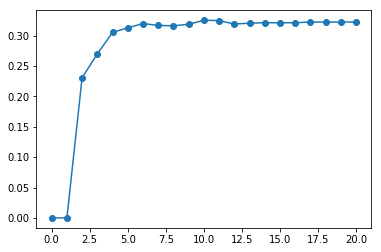

In [46]:
x_axis = np.linspace(0, m, len(max_depth)+2, dtype=int)

plt.plot(x_axis, QK, '-o')
plt.show()

## Final Model

In [70]:
clf = init_lgbm(x_train, y_train, 0.01331578947368421, 0.8, 50, 10)

In [71]:
#Prediction
y_pred=clf.predict(x_test)
#convert into single values
y_pred = np.argmax(y_pred, axis=1)

In [81]:
submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': y_pred.astype(np.int32)})
print(submission.head())
submission.to_csv('submission.csv', index=False)

   AdoptionSpeed      PetID
0              2  378fcc4fc
1              4  73c10e136
2              4  72000c4c5
3              4  e147a4b9f
4              4  43fbba852


PermissionError: [Errno 13] Permission denied: 'submission.csv'